In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.datasets import imdb
from sklearn import preprocessing,metrics,manifold
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,cross_val_predict
from imblearn.over_sampling import ADASYN,SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
import collections
import matplotlib.patches as mpatches
from sklearn.metrics import accuracy_score
%matplotlib inline
from sklearn.preprocessing import RobustScaler
import xgboost
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import classification_report,roc_auc_score,roc_curve,r2_score,recall_score,confusion_matrix,precision_recall_curve
from collections import Counter
from sklearn.model_selection import StratifiedKFold,KFold,StratifiedShuffleSplit
from nltk import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD,SparsePCA
from sklearn.metrics import classification_report,confusion_matrix
from nltk.tokenize import word_tokenize
from collections import defaultdict
from collections import Counter
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
import nltk
from nltk.corpus import stopwords
import string
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import re

In [2]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
from datasets import load_dataset
import pandas as pd

# Завантаження IMDb набору даних
imdb_data = load_dataset("imdb")

# Перетворення в DataFrame (приклад для тренувальної вибірки)
train_df = pd.DataFrame(imdb_data["train"])
test_df = pd.DataFrame(imdb_data["test"])

# Перегляд перших рядків
print(train_df.head())


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

                                                text  label
0  I rented I AM CURIOUS-YELLOW from my video sto...      0
1  "I Am Curious: Yellow" is a risible and preten...      0
2  If only to avoid making this type of film in t...      0
3  This film was probably inspired by Godard's Ma...      0
4  Oh, brother...after hearing about this ridicul...      0


In [4]:
imdb_data.shape

{'train': (25000, 2), 'test': (25000, 2), 'unsupervised': (50000, 2)}

In [5]:
train_df

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0
...,...,...
24995,A hit at the time but now better categorised a...,1
24996,I love this movie like no other. Another time ...,1
24997,This film and it's sequel Barry Mckenzie holds...,1
24998,'The Adventures Of Barry McKenzie' started lif...,1


In [15]:
from collections import Counter
word_counts = Counter(" ".join(train_df['text']).split())
total_words = sum(word_counts.values())
common_words = sum([count for _, count in word_counts.most_common(14000)])
coverage = common_words / total_words
print(f"Покриття словника: {coverage * 100:.2f}%")

Покриття словника: 88.34%


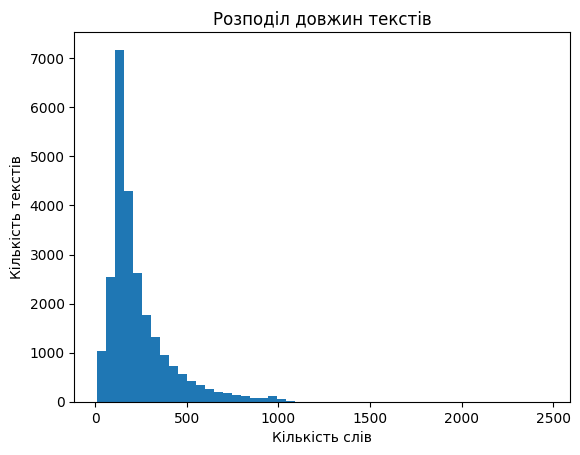

In [9]:
lengths = [len(text.split()) for text in train_df['text']]
plt.hist(lengths, bins=50)
plt.title("Розподіл довжин текстів")
plt.xlabel("Кількість слів")
plt.ylabel("Кількість текстів")
plt.show()

In [11]:
import numpy as np
percentiles = np.percentile(lengths, [80, 90, 95])
print(f"80-й перцентиль: {percentiles[0]}")
print(f"90-й перцентиль: {percentiles[1]}")
print(f"95-й перцентиль: {percentiles[2]}")

80-й перцентиль: 325.0
90-й перцентиль: 458.0
95-й перцентиль: 598.0


In [16]:
max_words = 14000
max_len = 458

In [17]:
def remove_punctuations(data):
    punct_tag=re.compile(r'[^\w\s]')
    data=punct_tag.sub(r'',data)
    return data

#Removes HTML syntaxes
def remove_html(data):
    html_tag=re.compile(r'<.*?>')
    data=html_tag.sub(r'',data)
    return data

#Removes URL data
def remove_url(data):
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data

#Removes Emojis
def remove_emoji(data):
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    data=emoji_clean.sub(r'',data)
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data

In [18]:
#train_df['text'], train_df['label']
train_df['text'] = train_df['text'].apply(lambda z: remove_punctuations(z))
train_df['text'] = train_df['text'].apply(lambda z: remove_html(z))
train_df['text'] = train_df['text'].apply(lambda z: remove_url(z))
train_df['text'] = train_df['text'].apply(lambda z: remove_emoji(z))

In [20]:
# Об'єднання всіх текстів із тренувальної вибірки в один рядок
def display_cloud(data):
    text = " ".join(review for review in data)

    # Створення об'єкта WordCloud з налаштуваннями
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(text)

    # Візуалізація WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

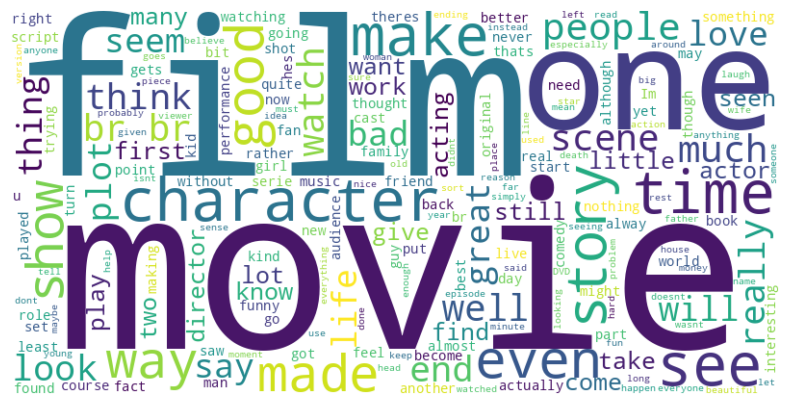

In [21]:
display_cloud(train_df['text'])

In [55]:
tok = Tokenizer(num_words=max_words)

# Fit tokenizer on training data
tok.fit_on_texts(train_df['text'].tolist())

# Transform texts to sequences
train_sequences = tok.texts_to_sequences(train_df['text'].tolist())
test_sequences = tok.texts_to_sequences(test_df['text'].tolist())

# Pad sequences
train_padded_sequences = sequence.pad_sequences(train_sequences, maxlen=max_len, truncating='post')
test_padded_sequences = sequence.pad_sequences(test_sequences, maxlen=max_len, truncating='post')

# Add padded sequences to DataFrame as a list
train_df['tokenized_review'] = train_padded_sequences.tolist()
test_df['tokenized_review'] = test_padded_sequences.tolist()

train_df

,text,label,tokenized_review
0,I rented I AM CURIOUSYELLOW from my video stor...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,I Am Curious Yellow is a risible and pretentio...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,If only to avoid making this type of film in t...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,This film was probably inspired by Godards Mas...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Oh brotherafter hearing about this ridiculous ...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
24995,A hit at the time but now better categorised a...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
24996,I love this movie like no other Another time I...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
24997,This film and its sequel Barry Mckenzie holds ...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
24998,The Adventures Of Barry McKenzie started life ...,1,"[1, 2434, 4, 3443, 626, 118, 14, 3, 5824, 722,..."


In [56]:
test_df['tokenized_review']

,tokenized_review
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...
24995,"[40, 182, 183, 5, 307, 968, 132, 4074, 8, 66, ..."
24996,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
24997,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
24998,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [70]:
X_val, X_test, Y_val, Y_test = train_test_split(test_df['tokenized_review'], test_df['label'], test_size=0.4, random_state=42)

In [71]:
test_df_dataset = pd.DataFrame()
test_df_dataset['tokenized_review'] = X_test.tolist()
test_df_dataset['label'] = Y_test.tolist()
test_df_dataset

,tokenized_review,label
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
...,...,...
9995,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
9996,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
9997,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
9998,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0


In [72]:
val_df_dataset = pd.DataFrame()
val_df_dataset['tokenized_review'] = X_val.tolist()
val_df_dataset['label'] = Y_val.tolist()
val_df_dataset

,tokenized_review,label
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
...,...,...
14995,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
14996,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
14997,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
14998,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1


In [73]:
# Check the distribution in the training set
print("\nTraining set distribution:")
print(test_df_dataset['label'].value_counts(normalize=True))



Training set distribution:
label
0    0.5038
1    0.4962
Name: proportion, dtype: float64


In [86]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, BatchNormalization, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Activation
from sklearn.utils.class_weight import compute_class_weight

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/layered_bidirectional.png?raw=1)

In [75]:
def RNN2():
    inputs = Input(name='inputs', shape=[max_len])
    layer = Embedding(input_dim=max_words, output_dim=128, input_length=max_len)(inputs)
    layer = LSTM(64, dropout=0.2)(layer)
    layer = Dense(128, name='FC1', kernel_regularizer=l2(0.001))(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1, name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs, outputs=layer)
    return model


In [87]:
def RNN_CNN():
    inputs = Input(name='inputs', shape=[max_len])
    layer = Embedding(input_dim=max_words, output_dim=128, input_length=max_len)(inputs)
    layer = Conv1D(filters=32, kernel_size=10, padding='same', activation='relu')(layer)
    layer = MaxPooling1D(pool_size=2)(layer)
    layer = LSTM(64, dropout=0.2)(layer)
    layer = Dense(128, name='FC1', kernel_regularizer=l2(0.001))(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1, name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs, outputs=layer)
    return model


In [94]:
def RNN_Bidirectional():
    inputs = Input(name='inputs', shape=[max_len])
    layer = Embedding(input_dim=max_words, output_dim=128, input_length=max_len)(inputs)
    layer = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(layer)
    layer = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(layer)
    layer = Dense(128, kernel_regularizer=l2(0.001))(layer)
    layer = BatchNormalization()(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1)(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs, outputs=layer)
    return model


In [76]:
def plot_visualization(history):
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [77]:
classification = ['positive', 'negative']

In [91]:
def training_RNN(model, train_dataset, val_dataset, test_dataset, epochs=5):
    print(f"Training model RNN")

    # Optimizer setup
    #optimizer = Adam(0.001, beta_1=0.9, beta_2=0.999)
    optimizer = RMSprop(learning_rate=0.0005, rho=0.9, epsilon=1e-07)

    # Compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    # Compute class weights

    y_train = train_dataset['label']
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights = dict(enumerate(class_weights))

    # Callbacks
    early_stopping_monitor = EarlyStopping(patience=3,
                                           monitor='val_loss',
                                           min_delta=0.00001,
                                           restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                                  patience=1,
                                  verbose=1,
                                  factor=0.5,
                                  min_lr=1e-6)

    train_history = model.fit(
        np.array(train_dataset['tokenized_review'].to_list()),
        y_train,
        validation_data=(np.array(val_dataset['tokenized_review'].to_list()),val_dataset['label']),
        epochs=epochs,
        batch_size=128,
        class_weight=class_weights,  # Use computed class weights
        callbacks=[reduce_lr, early_stopping_monitor],
        verbose=1)

    # Plot training visualization
    plot_visualization(train_history)

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(
        np.array(test_dataset['tokenized_review'].to_list()),
        test_dataset['label'])

    y_pred = model.predict(np.array(test_dataset['tokenized_review'].to_list())) > 0.5

    print(classification_report(test_dataset['label'], y_pred, target_names=classification))

    cm = confusion_matrix(test_dataset['label'], y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classification)
    disp.plot(cmap='Greens')
    plt.show()

    # Print metrics
    #print(f"Test Accuracy: {test_accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")
    print("-" * 60)


Training model RNN


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)                  │ (None, 458)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_8 (Embedding)              │ (None, 458, 128)            │       1,792,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC1 (Dense)                          │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ out_layer (Dense)                    │ (None, 1)                   │             129 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,849,857 (7.06 MB)

 Trainable params: 1,849,857 (7.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.6690 - loss: 0.6249 - val_accuracy: 0.8566 - val_loss: 0.3531 - learning_rate: 0.0010
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 224s 1s/step - accuracy: 0.9067 - loss: 0.2593 - val_accuracy: 0.8762 - val_loss: 0.3181 - learning_rate: 0.0010
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 956ms/step - accuracy: 0.9314 - loss: 0.1957
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
196/196 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.9313 - loss: 0.1958 - val_accuracy: 0.8719 - val_loss: 0.3727 - learning_rate: 0.0010
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 955ms/step - accuracy: 0.9601 - loss: 0.1253
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
196/196 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.9601 - loss: 0.1253 - val_accuracy: 0.8698 - val_loss: 0.3714 - learning_rate: 5.0000e-04
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 956ms/step - accuracy: 0.9761 - los

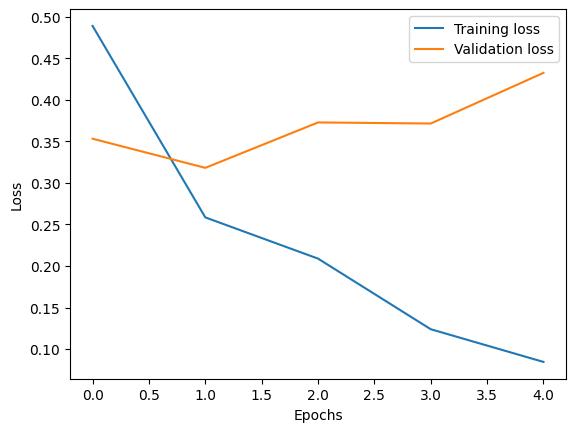

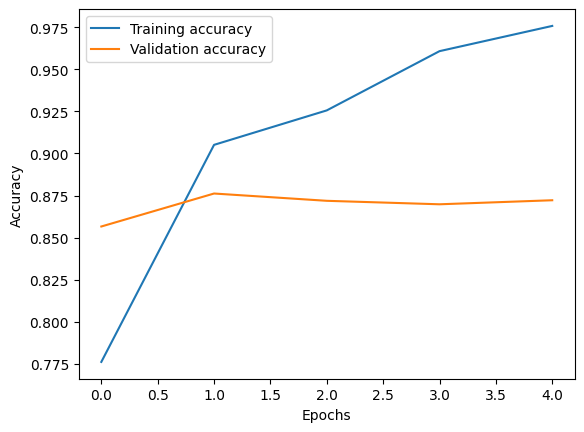

313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.8664 - loss: 0.3327
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

    positive       0.50      1.00      0.67      5038
    negative       0.00      0.00      0.00      4962

    accuracy                           0.50     10000
   macro avg       0.25      0.50      0.34     10000
weighted avg       0.25      0.50      0.34     10000



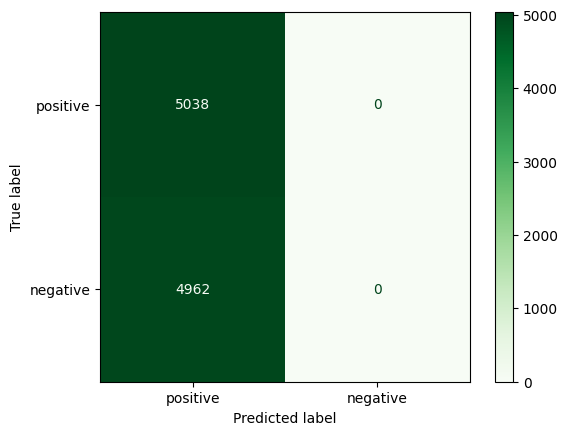

------------------------------------------------------------


In [85]:
model = RNN2()
training_RNN(model, train_df, val_df_dataset, test_df_dataset, epochs=10)

313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step
              precision    recall  f1-score   support

    positive       0.88      0.86      0.87      5038
    negative       0.86      0.88      0.87      4962

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



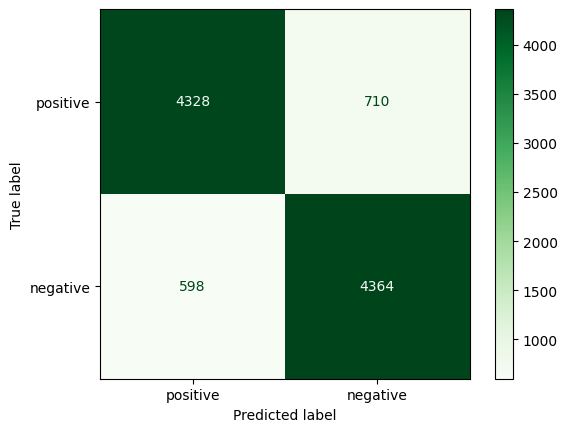

In [90]:
y_pred = model.predict(np.array(test_df_dataset['tokenized_review'].to_list())) > 0.5
print(classification_report(test_df_dataset['label'], y_pred, target_names=classification))

# Confusion Matrix
cm = confusion_matrix(test_df_dataset['label'], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classification)
disp.plot(cmap='Greens')
plt.show()

Training model RNN


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)                  │ (None, 458)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_9 (Embedding)              │ (None, 458, 128)            │       1,792,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 458, 32)             │          40,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 229, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC1 (Dense)                          │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_18 (Activation)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ out_layer (Dense)                    │ (None, 1)                   │             129 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_19 (Activation)           │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,866,273 (7.12 MB)

 Trainable params: 1,866,273 (7.12 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 191s 965ms/step - accuracy: 0.6571 - loss: 0.6206 - val_accuracy: 0.8831 - val_loss: 0.2989 - learning_rate: 0.0010
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 187s 957ms/step - accuracy: 0.9216 - loss: 0.2266 - val_accuracy: 0.8884 - val_loss: 0.2889 - learning_rate: 0.0010
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 816ms/step - accuracy: 0.9501 - loss: 0.1528
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
196/196 ━━━━━━━━━━━━━━━━━━━━ 188s 958ms/step - accuracy: 0.9501 - loss: 0.1529 - val_accuracy: 0.8595 - val_loss: 0.3765 - learning_rate: 0.0010
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 836ms/step - accuracy: 0.9717 - loss: 0.0953
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
196/196 ━━━━━━━━━━━━━━━━━━━━ 205s 976ms/step - accuracy: 0.9717 - loss: 0.0953 - val_accuracy: 0.8756 - val_loss: 0.4019 - learning_rate: 5.0000e-04
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - accuracy: 

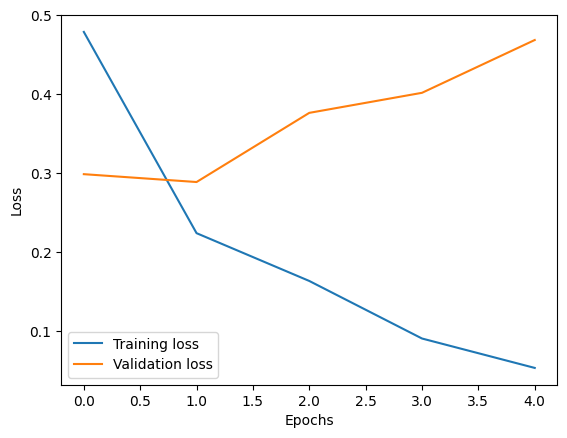

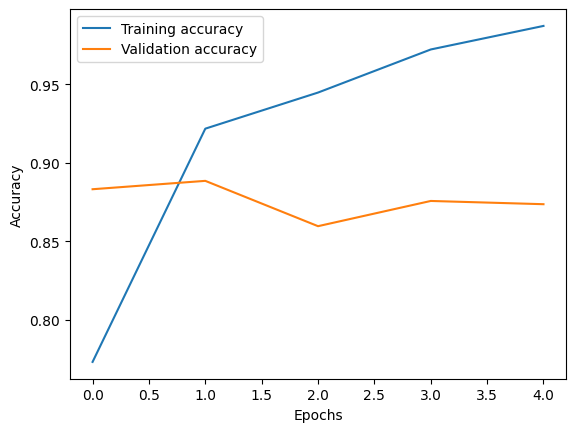

313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 69ms/step - accuracy: 0.8777 - loss: 0.3076


ValueError: Exception encountered when calling MaxPooling1D.call().

[1mNegative dimension size caused by subtracting 2 from 1 for '{{node functional_9_1/max_pooling1d_1/MaxPool1d}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 1, 2, 1], padding="VALID", strides=[1, 1, 2, 1]](functional_9_1/max_pooling1d_1/MaxPool1d/ExpandDims)' with input shapes: [32,1,1,32].[0m

Arguments received by MaxPooling1D.call():
  • inputs=tf.Tensor(shape=(32, 1, 32), dtype=float32)

In [88]:
modelCNN = RNN_CNN()
training_RNN(modelCNN, train_df, val_df_dataset, test_df_dataset, epochs=10)

313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step
              precision    recall  f1-score   support

    positive       0.88      0.88      0.88      5038
    negative       0.88      0.88      0.88      4962

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



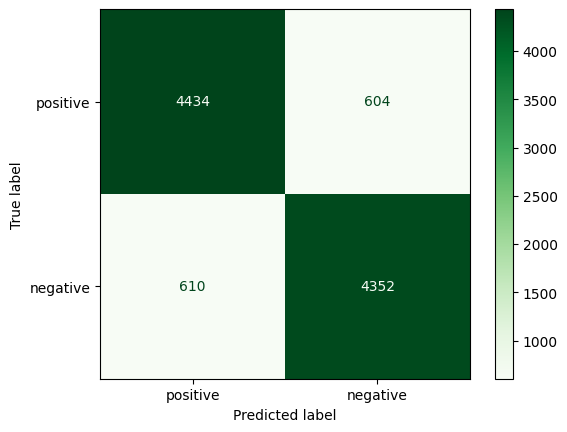

In [96]:
y_pred = modelCNN.predict(np.array(test_df_dataset['tokenized_review'].to_list())) > 0.5
print(classification_report(test_df_dataset['label'], y_pred, target_names=classification))

# Confusion Matrix
cm = confusion_matrix(test_df_dataset['label'], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classification)
disp.plot(cmap='Greens')
plt.show()

Training model RNN


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)                  │ (None, 458)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_11 (Embedding)             │ (None, 458, 128)            │       1,792,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 458, 256)            │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_20 (Activation)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_21 (Activation)           │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,236,673 (8.53 MB)

 Trainable params: 2,236,417 (8.53 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1389s 7s/step - accuracy: 0.6323 - loss: 0.7316 - val_accuracy: 0.8200 - val_loss: 0.6567 - learning_rate: 5.0000e-04
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1431s 7s/step - accuracy: 0.8421 - loss: 0.4484 - val_accuracy: 0.8369 - val_loss: 0.4434 - learning_rate: 5.0000e-04
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1398s 7s/step - accuracy: 0.8680 - loss: 0.3818 - val_accuracy: 0.8490 - val_loss: 0.3955 - learning_rate: 5.0000e-04
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8979 - loss: 0.3066
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
196/196 ━━━━━━━━━━━━━━━━━━━━ 1399s 7s/step - accuracy: 0.8979 - loss: 0.3066 - val_accuracy: 0.8384 - val_loss: 0.4037 - learning_rate: 5.0000e-04
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9170 - loss: 0.2541
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
196/196 ━━━━━━━━━━━━━━━━━━━━ 1409s 7s/step - accuracy: 0.

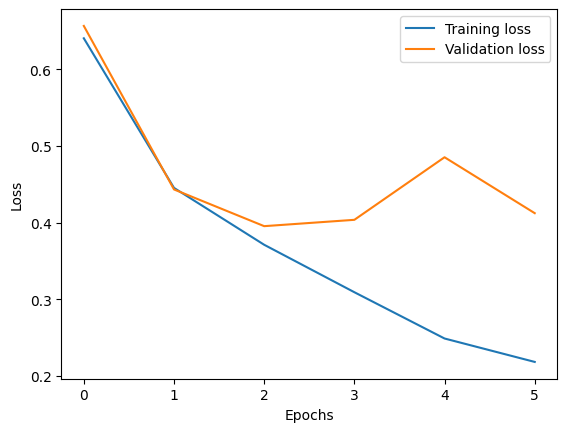

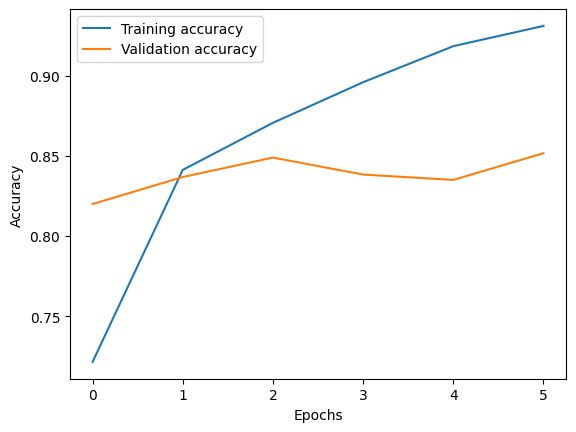

313/313 ━━━━━━━━━━━━━━━━━━━━ 234s 745ms/step - accuracy: 0.8431 - loss: 0.4137
313/313 ━━━━━━━━━━━━━━━━━━━━ 236s 752ms/step
              precision    recall  f1-score   support

    positive       0.83      0.87      0.85      5038
    negative       0.86      0.82      0.84      4962

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000



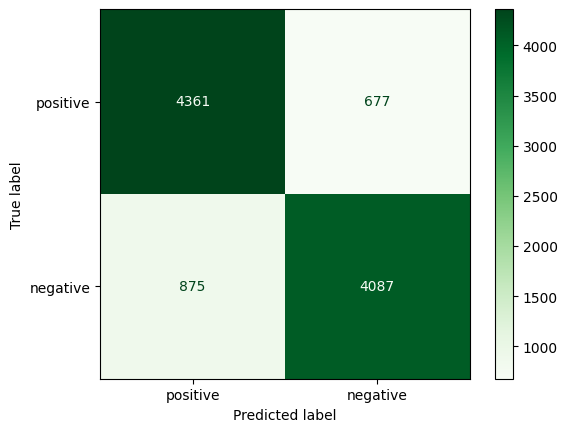

------------------------------------------------------------


In [95]:
model_Bidirectional = RNN_Bidirectional()
training_RNN(model_Bidirectional, train_df, val_df_dataset, test_df_dataset, epochs=10)